## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate
in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:01<00:00, 15656076.55it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 296986.31it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5044278.38it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18990569.03it/s]


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [19]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.Linear(200, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [14]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
        LogSoftmax-5                   [-1, 10]               0
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


Your experiments come here:

In [20]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

# Your experiments, training and validation loops here

In [42]:
import os
import json
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt

class TrainerLogger:
    def __init__(self, logging_dir: Union[str, None]=None):
        self.logging_dir = logging_dir
        if logging_dir != None:
            os.makedirs(self.logging_dir, exist_ok=True)
        self.history = {"epoch": [], "Loss/Train": [], "Loss/Test": [], "Accuracy/Train": [], "Accuracy/Test": []}

    def log(self, values):
        for key, value in values.items():
            if key in self.history:
                self.history[key].append(value)
            else:
                self.history[key] = [value]

        self.save_to_json("history")

    def save_to_json(self, filename):
        if self.logging_dir is not None:
            filepath = os.path.join(self.logging_dir, f"{filename}.json")
            with open(filepath, 'w') as json_file:
                json.dump(self.history, json_file)

    def plot_summary(self, keys):
        fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
        for key in keys:
            if key not in self.history:
                print(f"Key '{key}' not found in history.")
                continue
            plt.plot(self.history["epoch"], self.history[key], label=key)
        ax.set_title(f"{'/'.join(keys)}", fontsize=20)
        ax.set_xlabel("Epochs", fontsize=20)
        ax.set_ylabel("loss", fontsize=20)
        ax.legend()
        ax.set_xlim(left=0)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.grid(False)
        plt.show()

In [56]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def full_loop(model, num_epochs, train_loader, test_loader, optimizer, loss_fn, logger, device=None):
    model.to(device)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in tqdm(range(num_epochs)):
        epoch_train_loss = []
        epoch_test_loss = []
        epoch_test_accuracy = []
        epoch_train_accuracy = []

        model.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())
            preds = logits.argmax(axis=1)
            epoch_train_accuracy.append(accuracy_score(preds.cpu().numpy(), targets.cpu().numpy()))

        model.eval()
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                logits = model(data)
                loss = loss_fn(logits, targets)
                epoch_test_loss.append(loss.item())
                preds = logits.max(1)[1].data
                epoch_test_accuracy.append(accuracy_score(preds.cpu().numpy(), targets.cpu().numpy()))

        test_accuracy.append(np.mean(epoch_test_accuracy))
        train_accuracy.append(np.mean(epoch_train_accuracy))
        train_loss.append(np.mean(epoch_train_loss))
        test_loss.append(np.mean(epoch_test_loss))

        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy[-1]:.3f}, Test Accuracy: {test_accuracy[-1]:.3f}')
        logger.log({"epoch": epoch,
                    "Loss/Train": np.mean(epoch_train_loss),
                    "Loss/Test": np.mean(epoch_test_loss),
                    })

In [21]:
logger = TrainerLogger("./fashionmnist-results")
full_loop(model, 12, train_loader, test_loader, opt, loss_func, logger, device=device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0: Train Accuracy: 0.805, Test Accuracy: 0.842
Epoch 1: Train Accuracy: 0.854, Test Accuracy: 0.859
Epoch 2: Train Accuracy: 0.868, Test Accuracy: 0.862
Epoch 3: Train Accuracy: 0.877, Test Accuracy: 0.866
Epoch 4: Train Accuracy: 0.884, Test Accuracy: 0.874
Epoch 5: Train Accuracy: 0.890, Test Accuracy: 0.870
Epoch 6: Train Accuracy: 0.894, Test Accuracy: 0.877
Epoch 7: Train Accuracy: 0.898, Test Accuracy: 0.870
Epoch 8: Train Accuracy: 0.901, Test Accuracy: 0.878
Epoch 9: Train Accuracy: 0.905, Test Accuracy: 0.885
Epoch 10: Train Accuracy: 0.908, Test Accuracy: 0.878
Epoch 11: Train Accuracy: 0.909, Test Accuracy: 0.887


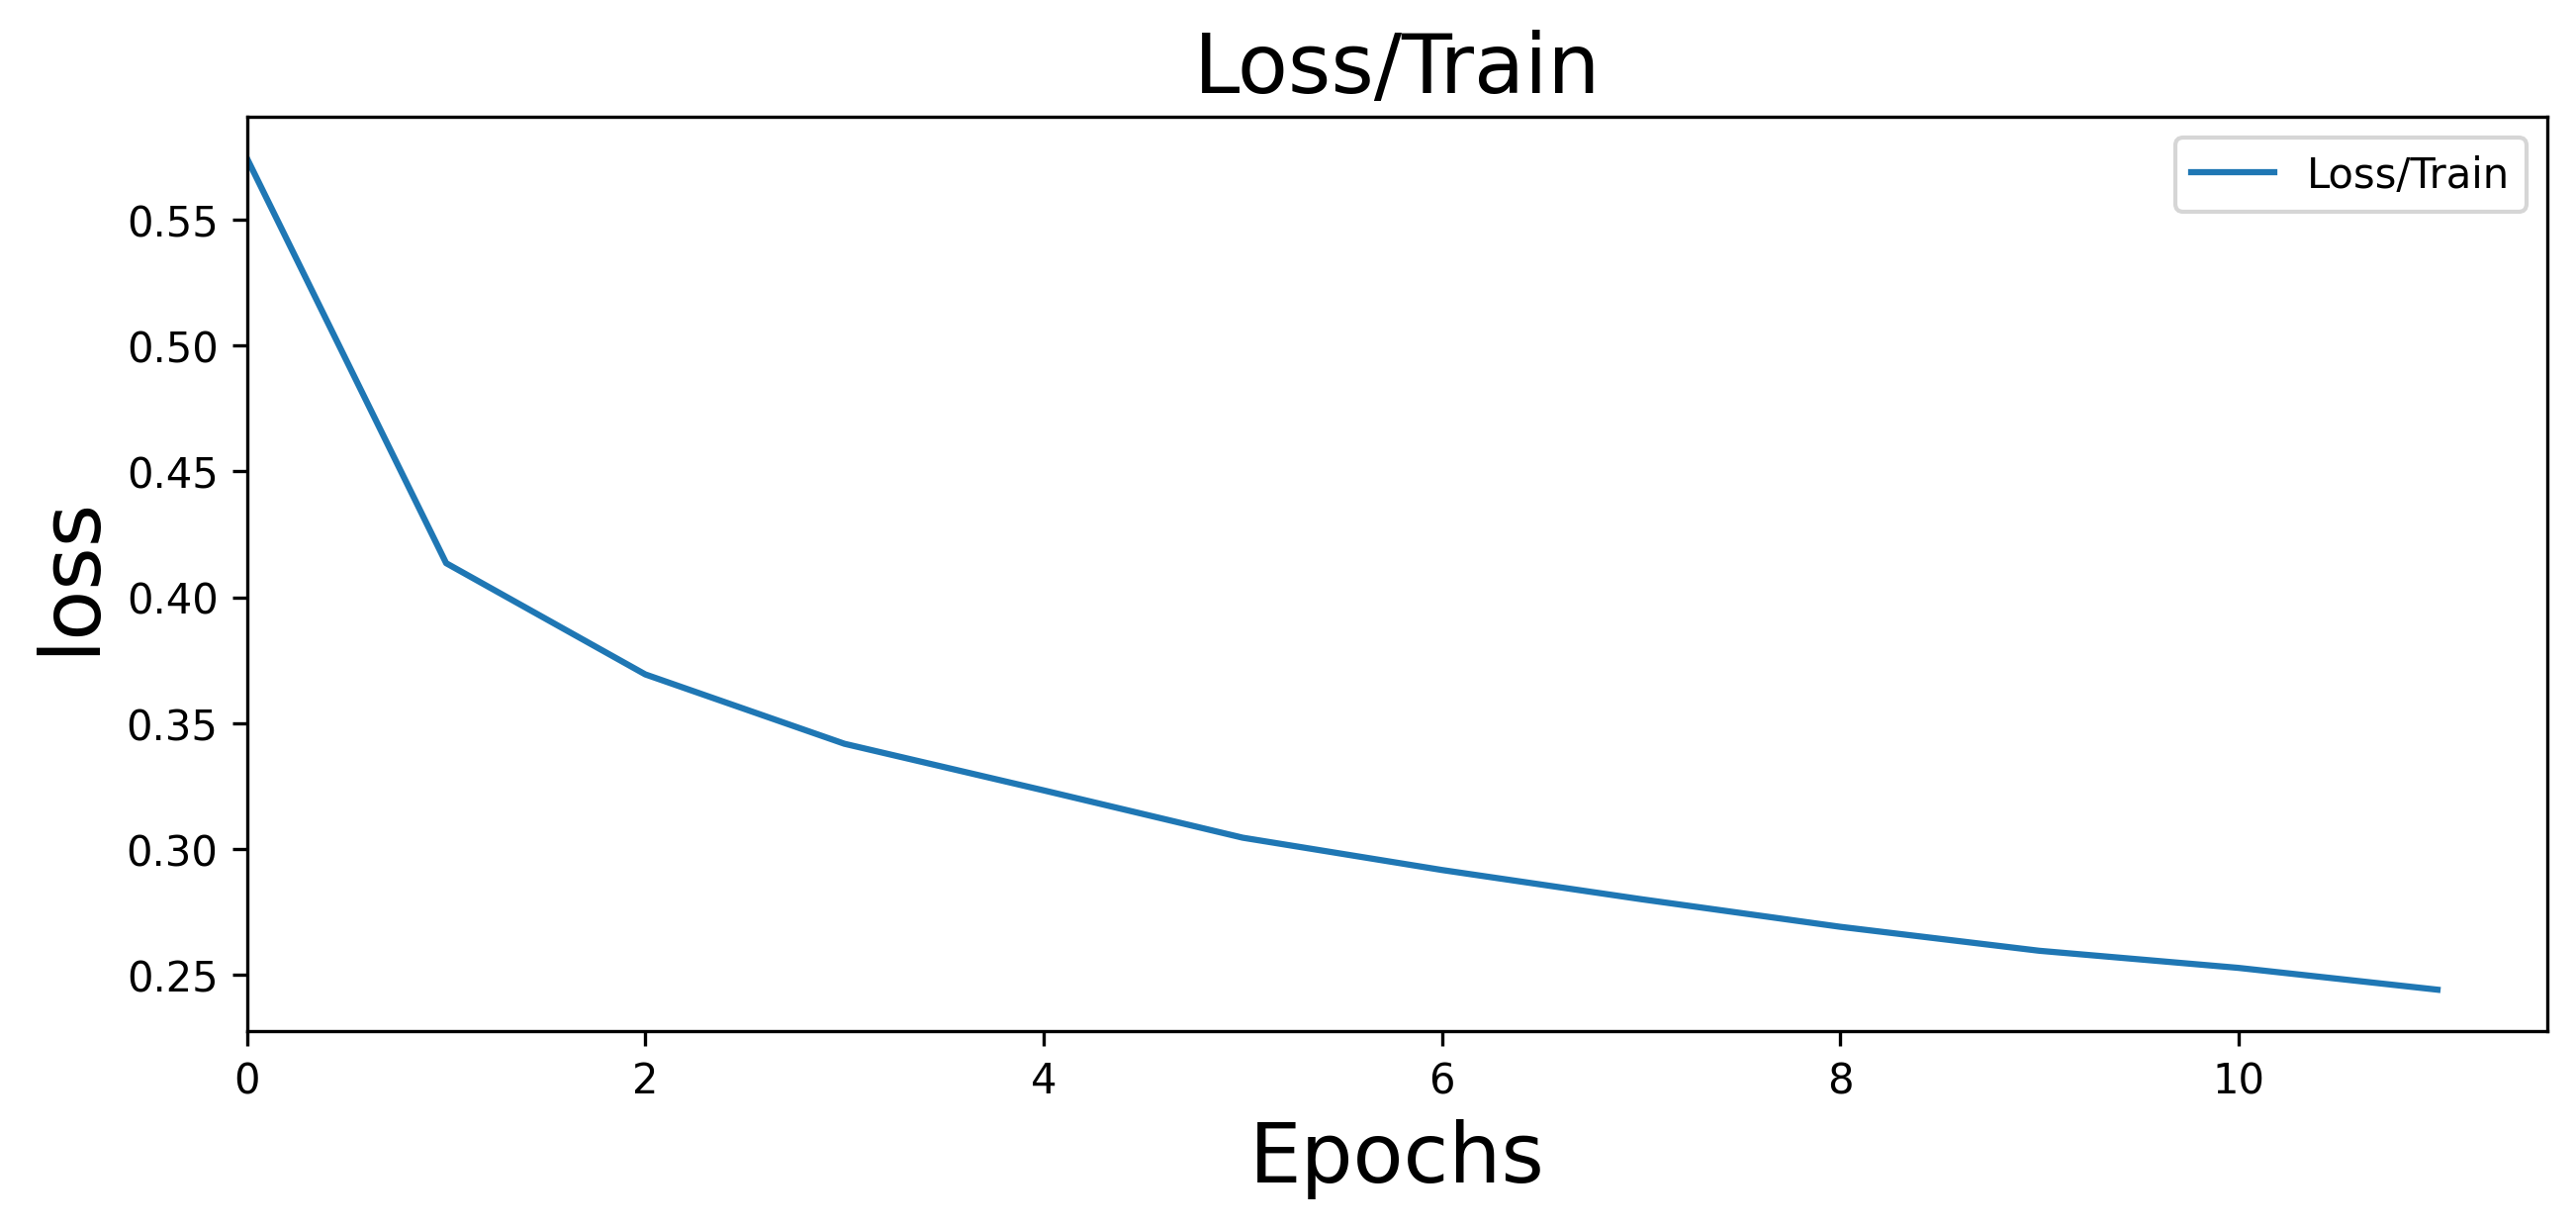

In [22]:
logger.plot_summary(["Loss/Train"])

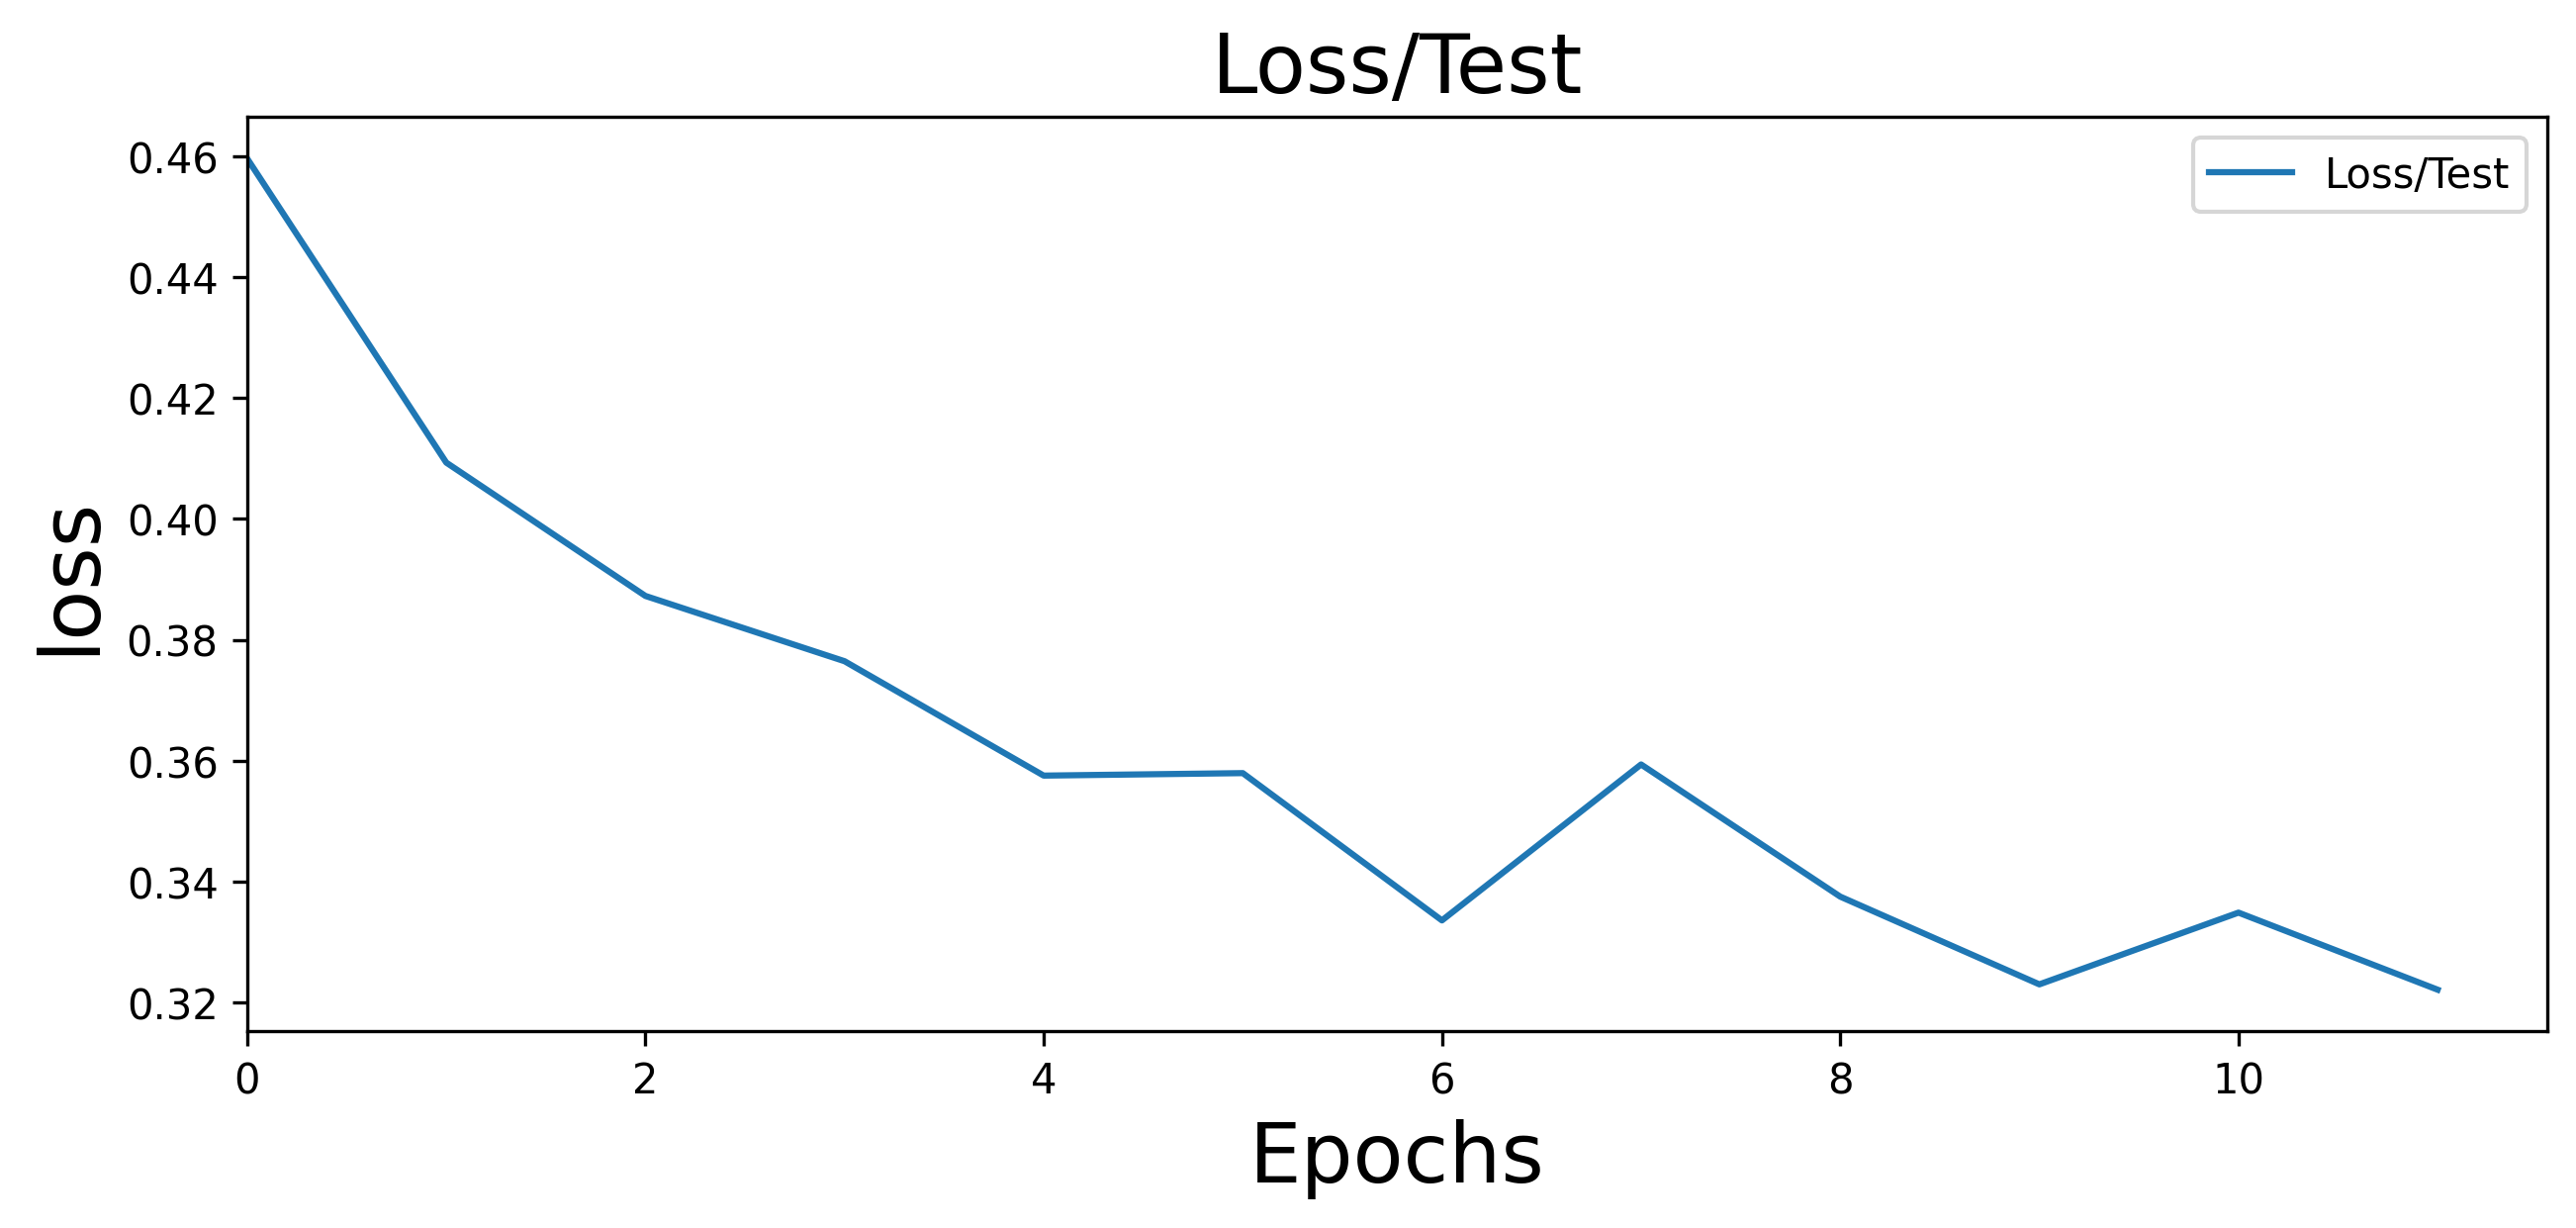

In [23]:
logger.plot_summary(["Loss/Test"])

From logger's plot we may conclude that networks hasen't been overfitted yet.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [35]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 80),
            nn.ReLU(),
            nn.Linear(80, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [36]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 100]          20,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 80]           8,080
              ReLU-7                   [-1, 80]               0
            Linear-8                   [-1, 64]           5,184
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 195,174
Trainable params: 195,174
Non-trainable params: 0
-------------------------------

In [44]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

# Your experiments, come here

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0: Train Accuracy: 0.730, Test Accuracy: 0.799
Epoch 1: Train Accuracy: 0.842, Test Accuracy: 0.840
Epoch 2: Train Accuracy: 0.859, Test Accuracy: 0.852
Epoch 3: Train Accuracy: 0.870, Test Accuracy: 0.848
Epoch 4: Train Accuracy: 0.879, Test Accuracy: 0.869
Epoch 5: Train Accuracy: 0.885, Test Accuracy: 0.865
Epoch 6: Train Accuracy: 0.889, Test Accuracy: 0.877
Epoch 7: Train Accuracy: 0.893, Test Accuracy: 0.874
Epoch 8: Train Accuracy: 0.897, Test Accuracy: 0.864
Epoch 9: Train Accuracy: 0.900, Test Accuracy: 0.882
Epoch 10: Train Accuracy: 0.901, Test Accuracy: 0.880
Epoch 11: Train Accuracy: 0.905, Test Accuracy: 0.883


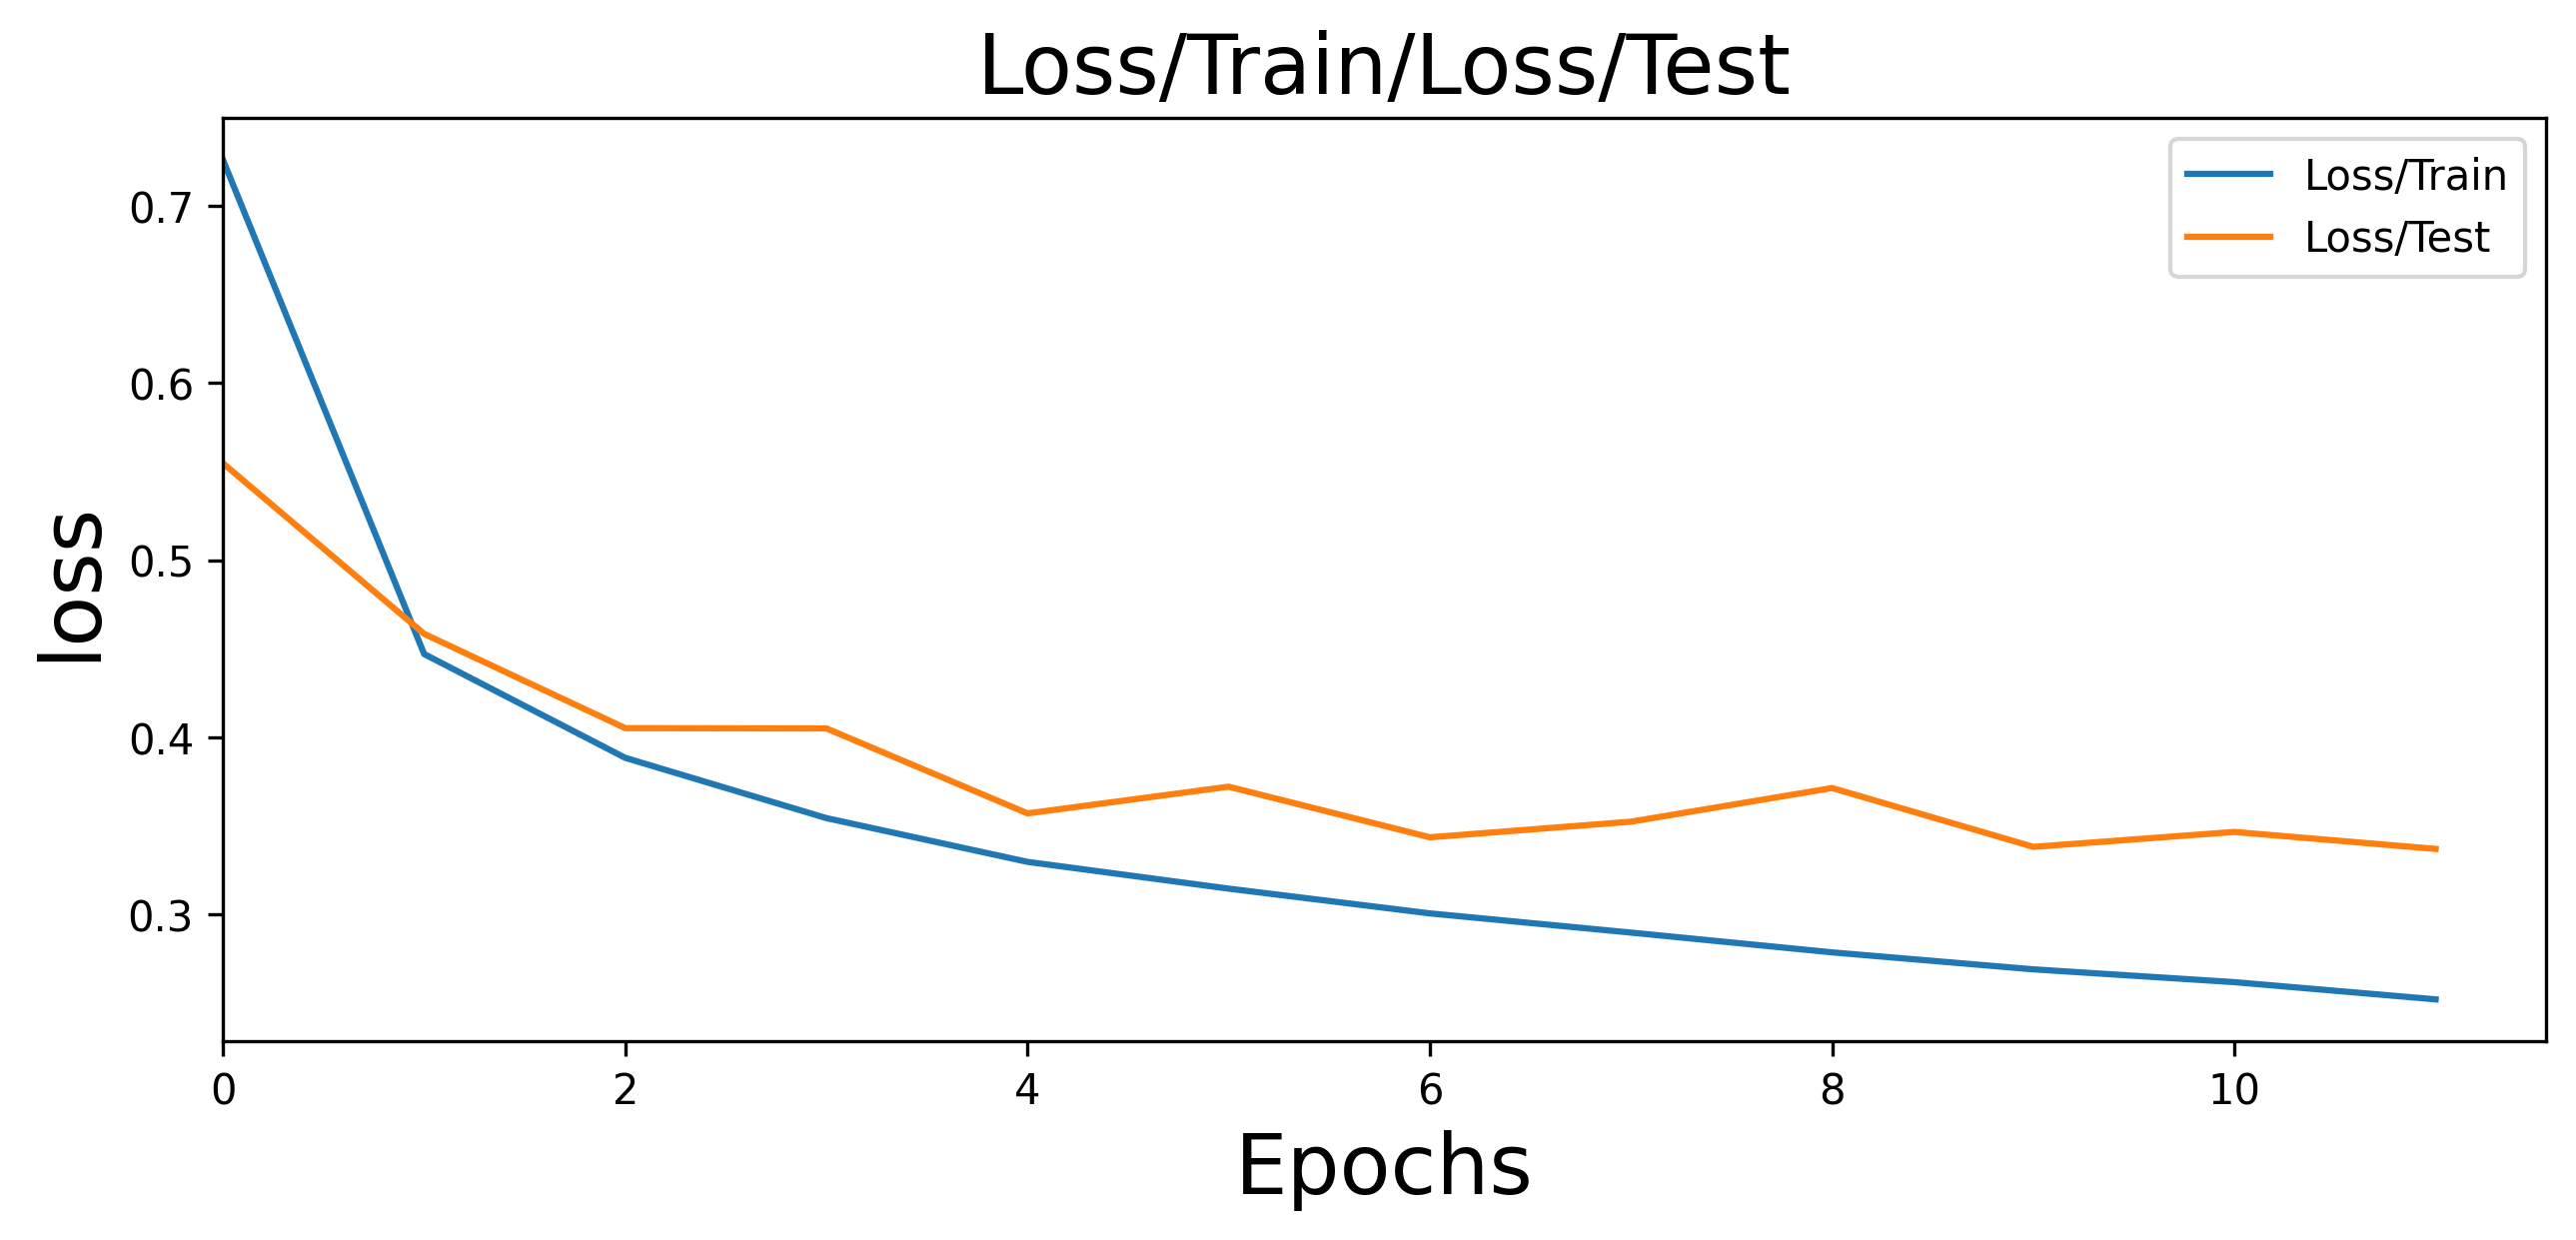

In [45]:
logger_overfitting = TrainerLogger("./fashionmnist-results-2")
full_loop(model, 12, train_loader, test_loader, opt, loss_func, logger_overfitting, device=device)

logger_overfitting.plot_summary(["Loss/Train", "Loss/Test"])

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [57]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [58]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
           Dropout-3                  [-1, 256]               0
              ReLU-4                  [-1, 256]               0
       BatchNorm1d-5                  [-1, 256]             512
            Linear-6                  [-1, 128]          32,896
           Dropout-7                  [-1, 128]               0
              ReLU-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.90
Estimated T

In [59]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

# Your experiments, come here

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0: Train Accuracy: 0.801, Test Accuracy: 0.835
Epoch 1: Train Accuracy: 0.838, Test Accuracy: 0.852
Epoch 2: Train Accuracy: 0.848, Test Accuracy: 0.860
Epoch 3: Train Accuracy: 0.854, Test Accuracy: 0.866
Epoch 4: Train Accuracy: 0.857, Test Accuracy: 0.867
Epoch 5: Train Accuracy: 0.859, Test Accuracy: 0.867
Epoch 6: Train Accuracy: 0.863, Test Accuracy: 0.868
Epoch 7: Train Accuracy: 0.865, Test Accuracy: 0.870
Epoch 8: Train Accuracy: 0.870, Test Accuracy: 0.874
Epoch 9: Train Accuracy: 0.870, Test Accuracy: 0.877
Epoch 10: Train Accuracy: 0.870, Test Accuracy: 0.875
Epoch 11: Train Accuracy: 0.870, Test Accuracy: 0.876


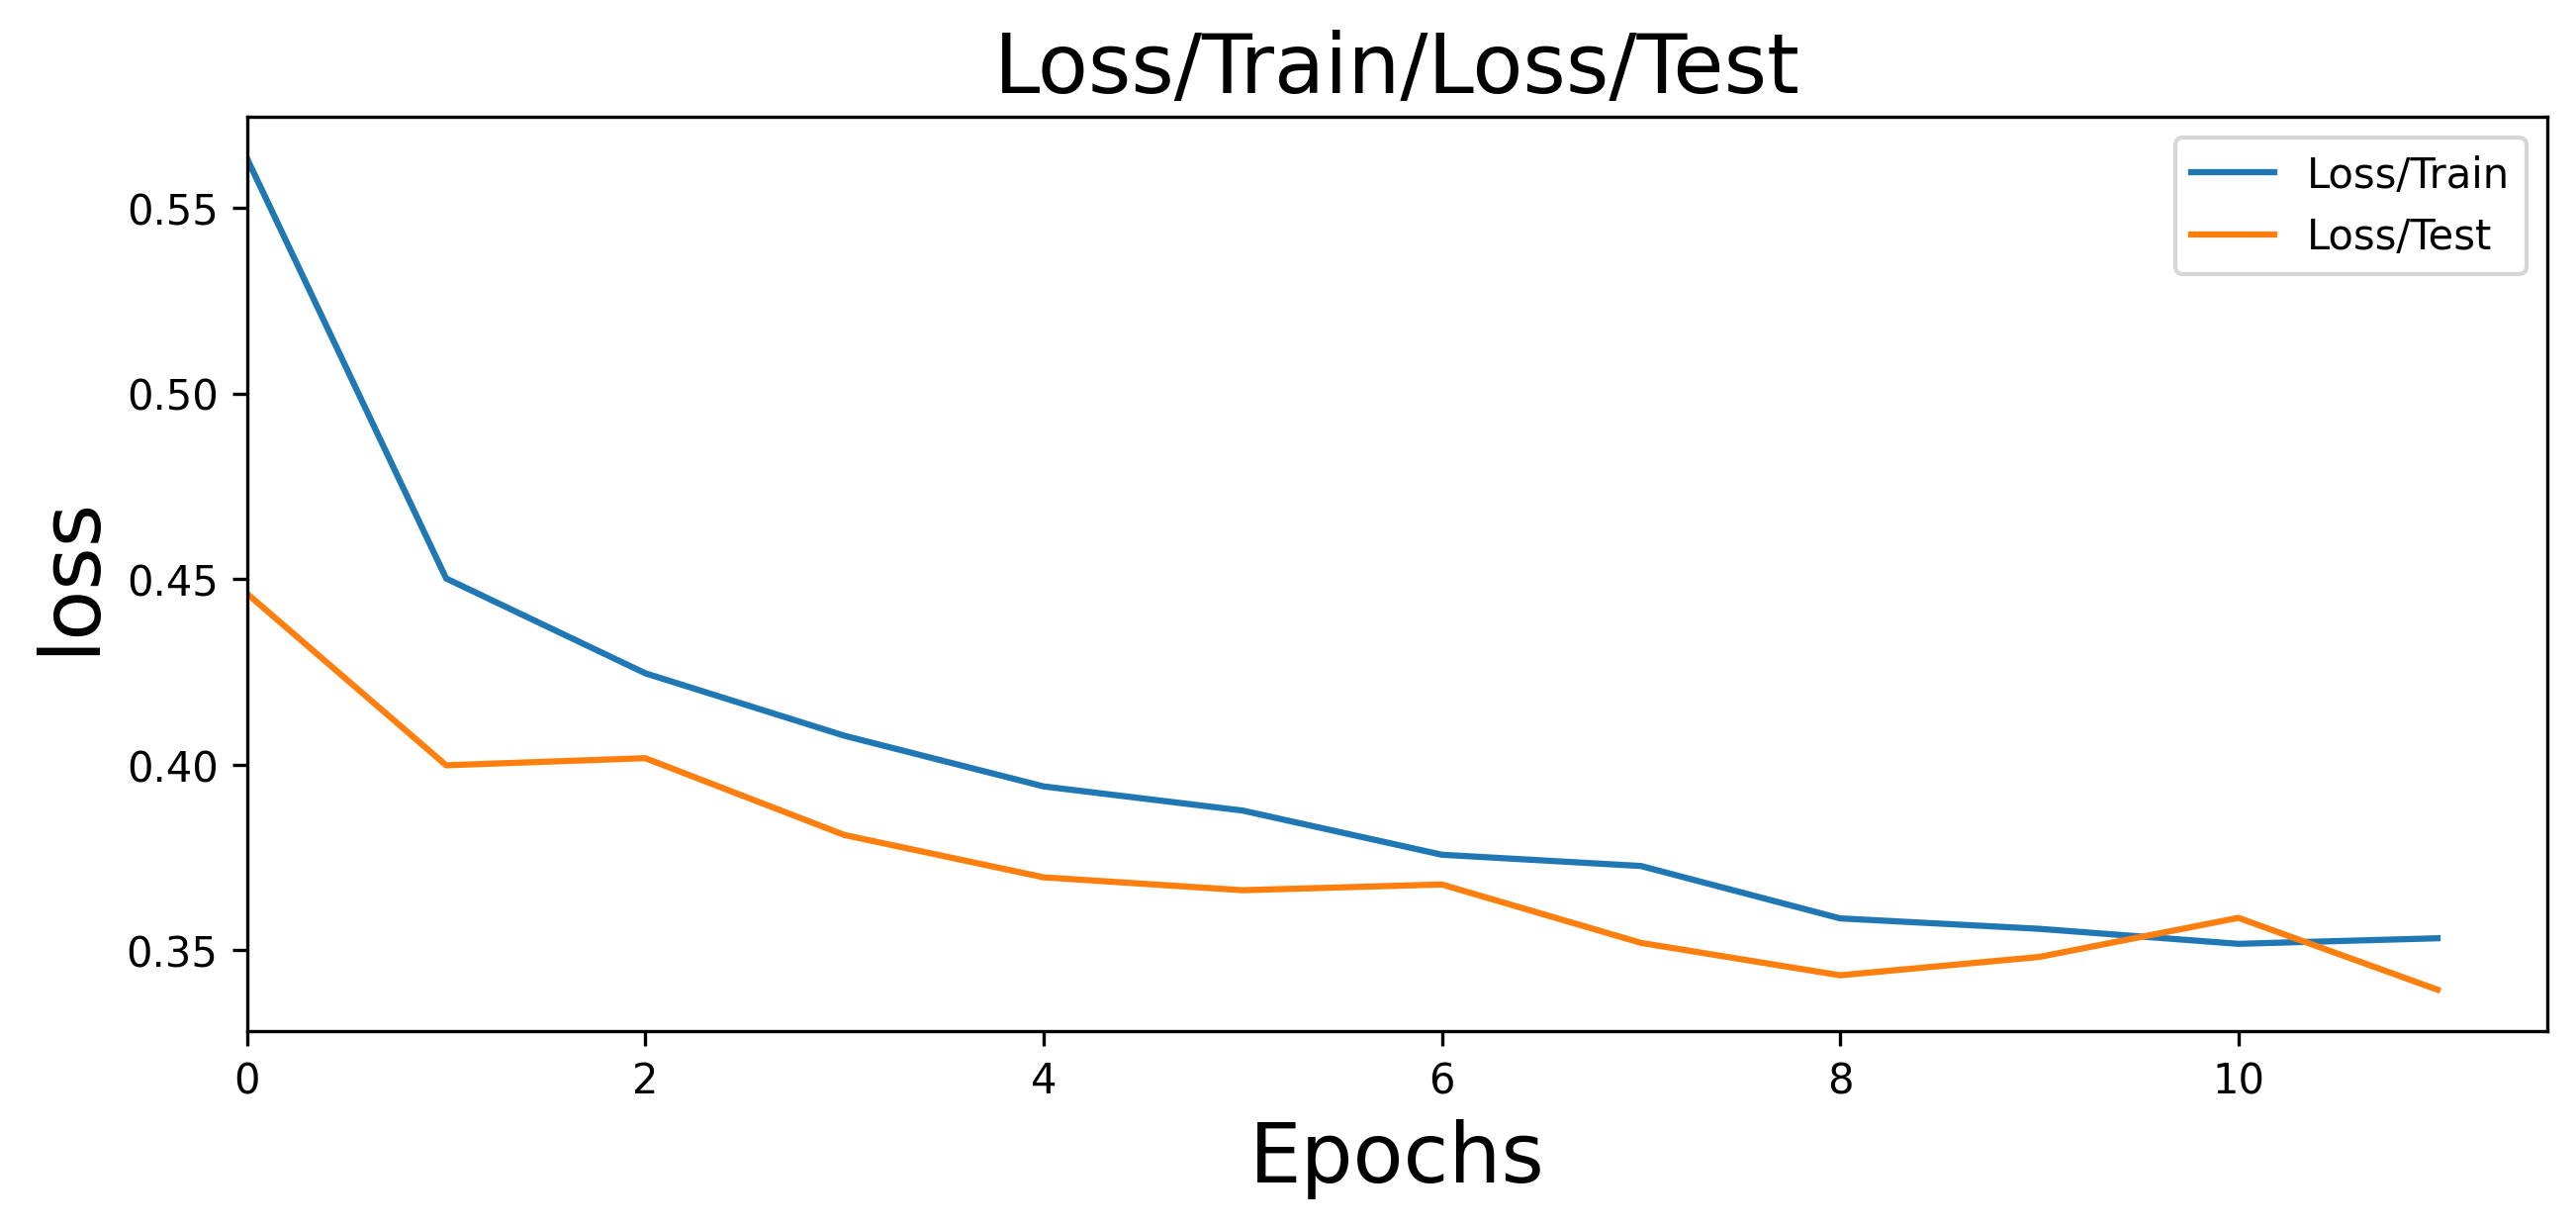

In [60]:
logger_fixed = TrainerLogger("./fashionmnist-results-3")
full_loop(model, 12, train_loader, test_loader, opt, loss_func, logger_fixed, device=device)

logger_fixed.plot_summary(["Loss/Train", "Loss/Test"])

### Conclusions:
_Write down small report with your conclusions and your ideas._

* In the first experiment, I trained a simple net and achieved the desired quality on the dataset.

* In the second one, I tried a more complex model configuration: simple "stack more layers" led to overfitting.

* In the third case, the situation was corrected by the placement of batch norm and dropout layers. Despite the fact that the linear layers have changed, overfitting was avoided in the third experiment.

* I also conducted an additional experiment below, which uses the same network as in the case of overfitting, and put the batch norms and dropouts there. I got a quite better results, but not so explicit, thats why I left it here.

One more test

In [61]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 80),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(80),
            nn.Linear(80, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [62]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

# Your experiments, come here

Epoch 1: Train Accuracy: 0.800, Test Accuracy: 0.832
Epoch 2: Train Accuracy: 0.816, Test Accuracy: 0.841
Epoch 3: Train Accuracy: 0.825, Test Accuracy: 0.848
Epoch 4: Train Accuracy: 0.830, Test Accuracy: 0.855
Epoch 5: Train Accuracy: 0.832, Test Accuracy: 0.853
Epoch 6: Train Accuracy: 0.836, Test Accuracy: 0.853
Epoch 7: Train Accuracy: 0.836, Test Accuracy: 0.859
Epoch 8: Train Accuracy: 0.839, Test Accuracy: 0.857
Epoch 9: Train Accuracy: 0.840, Test Accuracy: 0.862
Epoch 10: Train Accuracy: 0.839, Test Accuracy: 0.859
Epoch 11: Train Accuracy: 0.843, Test Accuracy: 0.850


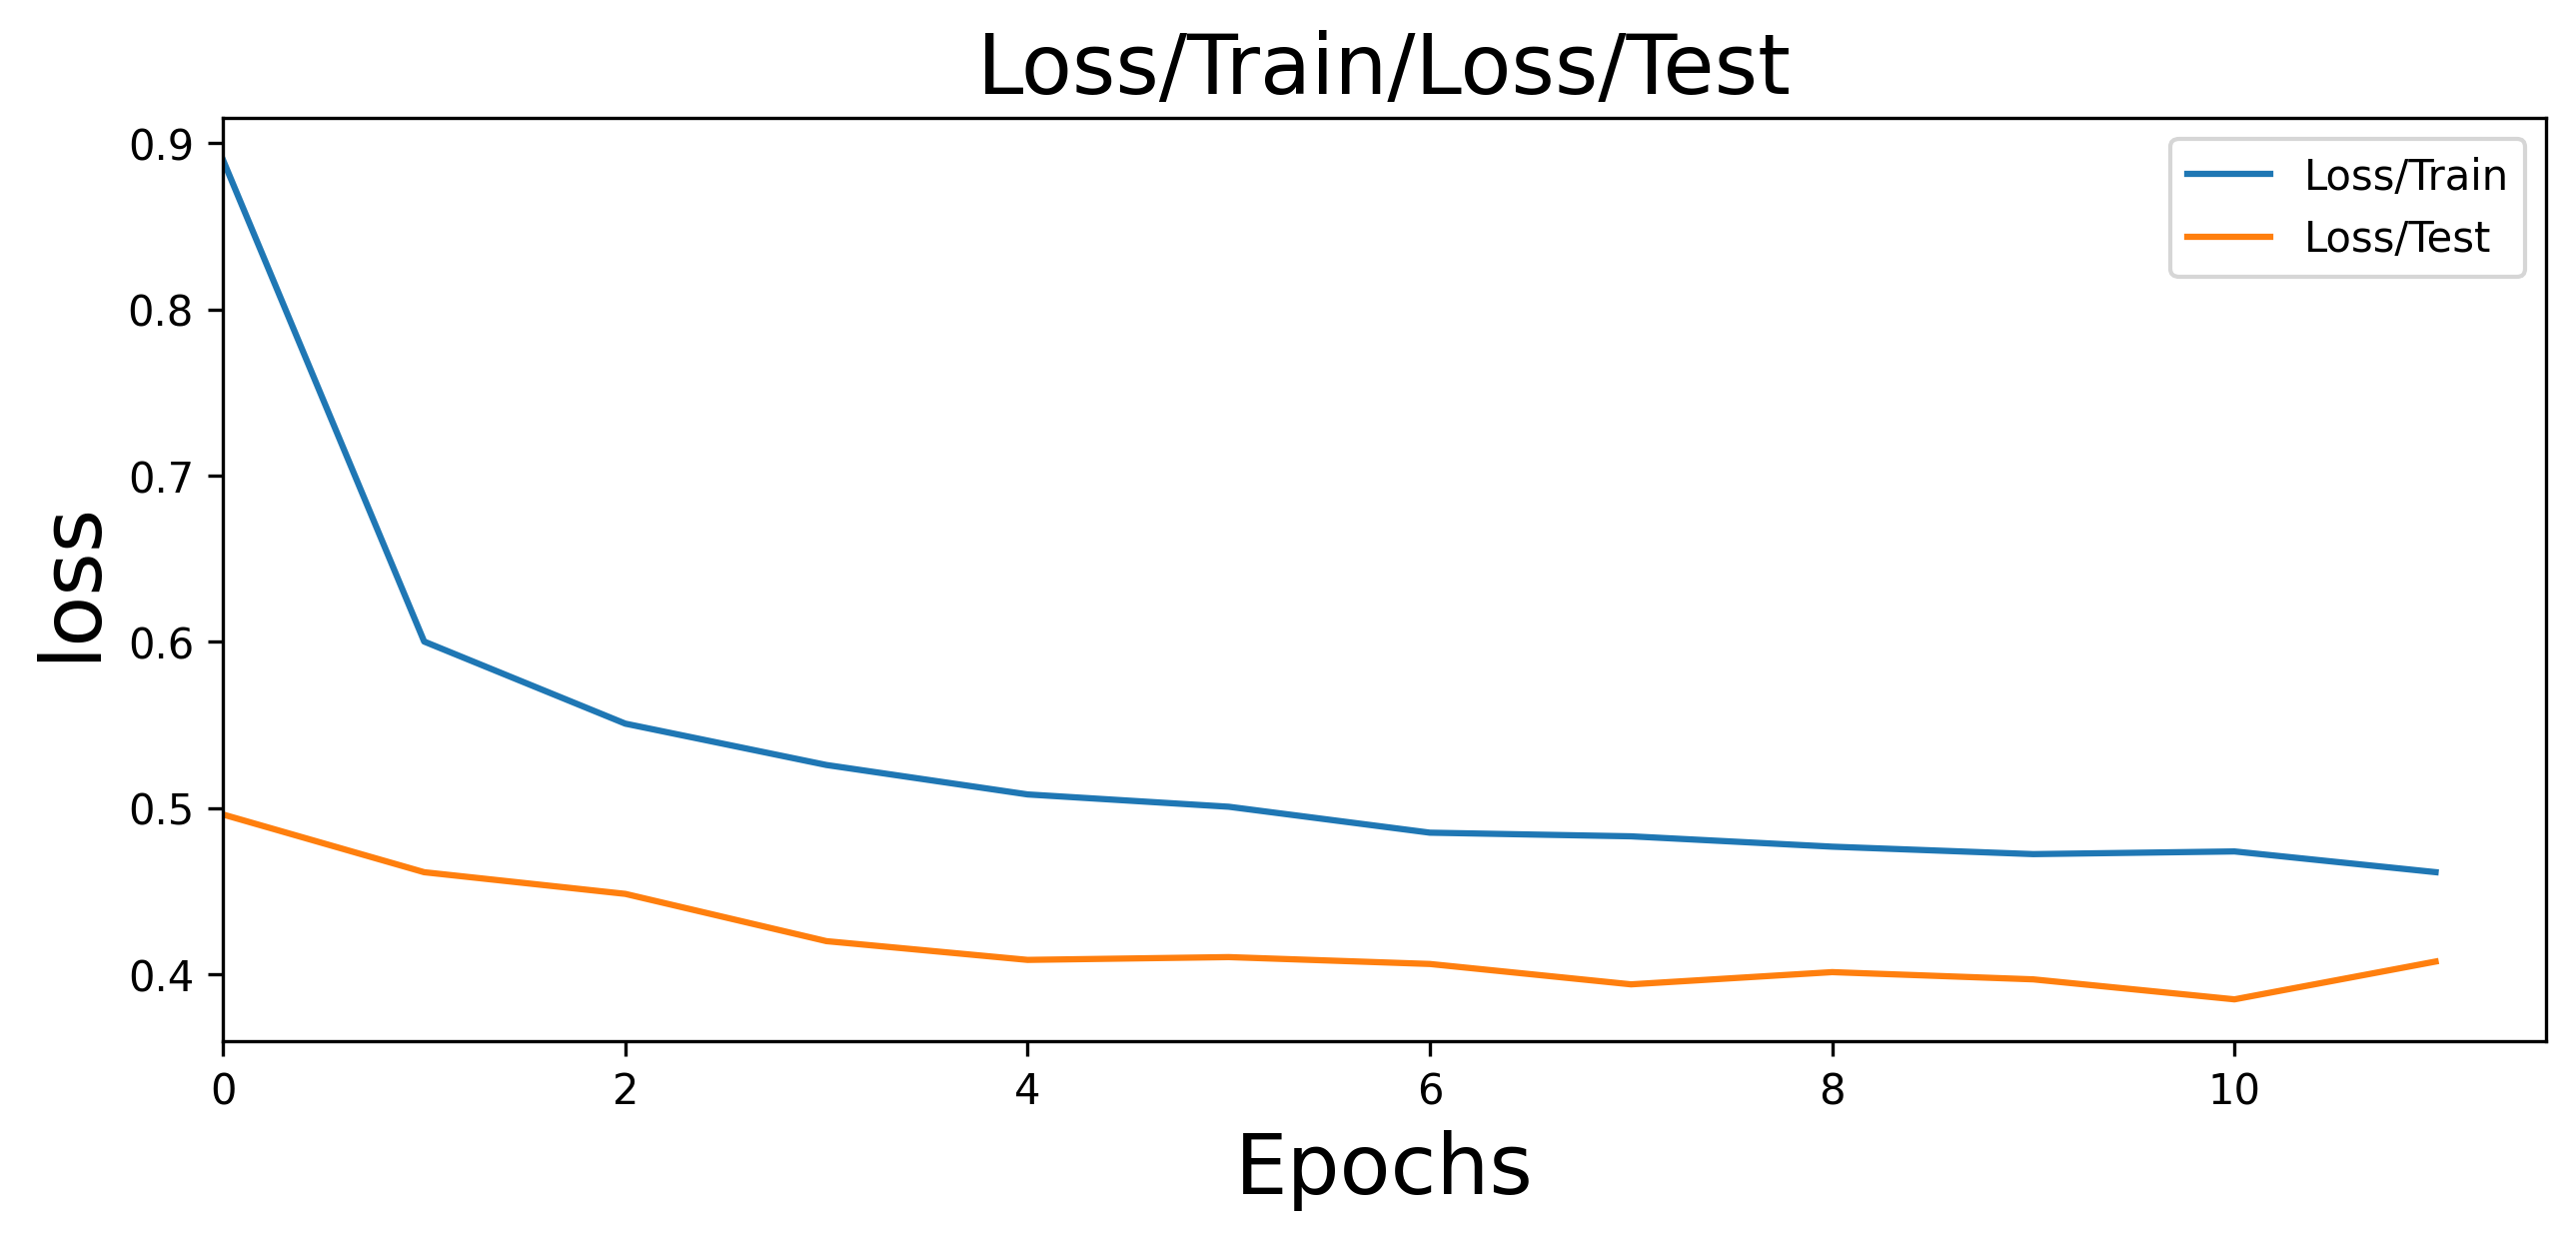

In [63]:
logger_test = TrainerLogger("./fashionmnist-results-4")
full_loop(model, 12, train_loader, test_loader, opt, loss_func, logger_test, device=device)

logger_test.plot_summary(["Loss/Train", "Loss/Test"])